In [1]:
# !pip install --user tables
# !pip install imblearn
# !pip3 install --force-reinstall tensorflow==2.8.0 --user 
# !pip3 install --upgrade tensorflow-gpu --user
# !pip3 install tensorflow_datasets --user
# !pip3 install numba
# !pip3 install PyWavelets
# !pip3 install imageio
# !pip3 install scikit-image
# !pip3 install psutil

import os, h5py, re, time, pywt, imageio, pickle, psutil, sys, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek, SMOTEENN
from tqdm.auto import tqdm
tqdm.pandas()

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from joblib import Parallel, delayed
import numba as nb
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import numpy as np   

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler

import keras_tuner as kt
from tensorflow import keras
from IPython.display import clear_output
import typing

from tensorflow_addons.utils.types import AcceptableDTypes
from typeguard import typechecked

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

C:\Users\Zhafran\.conda\envs\ExVodka\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('merge.csv')
df.head()

C:\Users\Zhafran\.conda\envs\ExVodka\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise,109C.TA_201510210555_NO
1,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise,109C.TA_201511061450_NO
2,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise,109C.TA_201511070220_NO
3,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise,109C.TA_201511140515_NO
4,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise,109C.TA_201512251850_NO


In [6]:
df.iloc[:, 13:30][df['trace_category']!='noise'].head()

,source_id,source_origin_time,source_origin_uncertainty_sec,source_latitude,source_longitude,source_error_sec,source_gap_deg,source_horizontal_uncertainty_km,source_depth_km,source_depth_uncertainty_km,source_magnitude,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg
235426,8556349,2006-07-23 15:58:50.88,0.47,33.7496,-117.4938,1.1119,107.466,4.6403,0.45,None,3.6,ml,None,None,0.92,102.09,159.3
235427,8860238,2006-11-03 15:56:42.73,0.24,32.7077,-116.0446,0.899,37.593,2.9542,9.2,None,4.3,mb,None,None,0.91,101.34,281.7
235428,8940123,2006-11-03 16:12:12.44,0.27,32.7253,-116.0348,0.8127,48.096,3.0397,12.66,None,3.6,ml,None,None,0.92,101.87,280.5
235429,9443190,2006-11-14 13:32:14.26,0.25,32.7063,-116.0241,0.9173,43.783,2.6112,11.5,None,3.8,ml,None,None,0.93,103.26,281.6
235430,9443449,2006-11-27 10:46:29.92,0.67,31.9679,-117.1944,1.0362,182.145,5.6607,7.26,None,3.6,ml,None,None,0.92,102.48,4.7


<AxesSubplot:xlabel='back_azimuth_deg', ylabel='Density'>

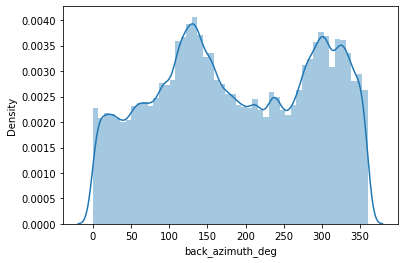

In [13]:
sns.distplot(df['back_azimuth_deg'][df['trace_category']!='noise'], kde=True)

In [3]:
def RandomUnderSampler(df_earthquake, random_state=24, size_underSample=20000):
    np.random.seed(random_state)
    index = np.random.randint(0, len(df_earthquake)+1, size=size_underSample)
    return df_earthquake.loc[index].reset_index(drop=True)

df_noise = df[df['trace_category']=='noise'][['p_arrival_sample', 's_arrival_sample',
                                              'source_magnitude', 'trace_name', 'trace_category']]
df_noise = df_noise.reset_index(drop=True)
df_noise = df_noise.fillna(-1)

df_earthquake = df[df['trace_category']=='earthquake_local'][['p_arrival_sample', 's_arrival_sample', 'back_azimuth_deg',
                                                              'source_magnitude', 'trace_name', 'trace_category']]
df_earthquake = df_earthquake.reset_index(drop=True)
df_earthquake_sample = RandomUnderSampler(df_earthquake, size_underSample=df_noise.shape[0],
                                   random_state=24)

In [4]:
df_2 = pd.concat([df_earthquake_sample, df_noise]).reset_index(drop=True)
rate = .4 # 0<=rate<=1, ketika rate 1 mengambil seluruh data (balanced), ketika 0 tidak ada data yg di ambil
df_2_slice = df_earthquake.groupby('trace_category', group_keys=False).apply(lambda x: x.sample(int(len(df_earthquake)*rate))) 

print(f'''
{display(df_earthquake.sample(5))}

DataFrame 2 Shape       : {df_earthquake.shape}
DataFrame 2 Sliced Shape: {df_2_slice.shape}
''')

,p_arrival_sample,s_arrival_sample,back_azimuth_deg,source_magnitude,trace_name,trace_category
527399,400.0,473.0,114.400,1.93,GDXB.NC_20130721134219_EV,earthquake_local
770755,1000.0,3768.0,116.427,3.50,OHAK.AT_20180927151929_EV,earthquake_local
23292,500.0,1893.0,22.200,3.30,ALN.HT_20100914071737_EV,earthquake_local
60135,700.0,809.0,31.600,1.46,B067.PB_20141204201722_EV,earthquake_local
607313,700.0,792.0,341.500,1.67,ID06.GS_20170912111559_EV,earthquake_local



None

DataFrame 2 Shape       : (1030231, 6)
DataFrame 2 Sliced Shape: (412092, 6)



In [146]:
X2 = np.zeros(500)
X2[int(round(250*(data.iloc[0]/np.pi + 1)))%500] = 1
X2.shape

(500,)

In [147]:
M = np.max(X2)
for i in range(len(X2)):
    if abs(X2[i]-M) < 1e-5:
        angle = np.pi*i/250 - np.pi
        break
# angle = np.pi*np.dot(np.array([i for i in range(500)]),X2)/500  # Averaging
angle

2.7771679057733776

In [48]:
X2 = np.zeros(500)
X2[int(round(250*(data.iloc[0]/np.pi + 1)))%500] = 1
X2.shape

NameError: name 'data' is not defined

In [6]:
X = df_2_slice['trace_name']
y = df_2_slice[['s_arrival_sample', 'source_magnitude', 'back_azimuth_deg']]
y['s_arrival_sample'] = y['s_arrival_sample'].map(lambda x: np.log(x))
y['source_magnitude'] = y['source_magnitude'].map(lambda x: np.log1p(x))
y['back_azimuth_deg'] = y['back_azimuth_deg'].map(lambda x: np.radians(x-180))
y['sin'] = y['back_azimuth_deg'].map(lambda x: np.sin(x))
y['cos'] = y['back_azimuth_deg'].map(lambda x: np.cos(x))
# y_back_az = y['back_azimuth_deg']
# y.drop(columns='back_azimuth_deg', inplace=True)

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size=0.6)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, train_size=0.5)

y_train_backAzimuth = y_train['back_azimuth_deg']
y_val_backAzimuth = y_val['back_azimuth_deg']
y_test_backAzimuth = y_test['back_azimuth_deg']

y_train.drop(columns='back_azimuth_deg', inplace=True)
y_val.drop(columns='back_azimuth_deg', inplace=True)
y_test.drop(columns='back_azimuth_deg', inplace=True)

print(f'''
X_train Shape: {X_train.shape}
X_test  Shape: {X_test.shape}
X_val   Shape: {X_val.shape}
''')

C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/2226519839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['s_arrival_sample'] = y['s_arrival_sample'].map(lambda x: np.log(x))
C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/2226519839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['source_magnitude'] = y['source_magnitude'].map(lambda x: np.log1p(x))
C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/2226519839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s


X_train Shape: (247255,)
X_test  Shape: (82418,)
X_val   Shape: (82419,)



C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/2226519839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cos'] = y['back_azimuth_deg'].map(lambda x: np.cos(x))


In [7]:
def get_waveform(trace_name):
    '''
    Kolom 1: East-West Channel
    Kolom 2: North-South Channel
    Kolom 3: Z (Vertical) Channel
    '''
    filename = "merge.hdf5"
    with h5py.File(filename, "r") as f:
        data = f.get('data/'+trace_name)
        data = np.array(data)
    return data

In [8]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def DenoiseWavelet(data, type='BayesShrink'):
    def BayesShrink():
        im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
                                   method='BayesShrink', mode='soft', 
                                   rescale_sigma=True, wavelet_levels=4)
        return im_bayes
    
    def VisuShrink():
        sigma_est = estimate_sigma(np.array(data), multichannel=True, average_sigmas=True)
        im_visu = denoise_wavelet(np.array(img), convert2ycbcr=True, multichannel=True,
                                  method='VisuShrink', mode='soft', wavelet_levels=4,
                                  sigma=sigma_est, rescale_sigma=True)
        
        return im_visu
    
    if type=='BayesShrink':
        return BayesShrink()
    elif type=='VisuShrink':
        return VisuShrink()

def create_data_2(data_feature, data_label, BATCH=128):
    def create_feature():
        rs = []
        for t in tqdm(data_feature.values):
            data_l = get_waveform(t)
            data_denoise = DenoiseWavelet(data_l, type='BayesShrink')
            rs.append(data_denoise)
        return np.array(rs)
    
    def create_label():
        return np.array(data_label.values)
    
    def create_dataset(feature, label): 
        gen = DataGenerator(feature, label, BATCH)
        return gen
    
    feature = create_feature()
    label = create_label()
    
    ts_dt = create_dataset(feature, label)
    print(f'\n{ts_dt}\n')
    return ts_dt # {'feature':feature, 'label':label}

In [9]:
dt_train = create_data_2(data_feature=X_train,
                          data_label=y_train)

  0%|          | 0/247255 [00:00<?, ?it/s]C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/3254799232.py:16: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
100%|██████████| 247255/247255 [2:11:44<00:00, 31.28it/s]  


In [10]:
dt_val = create_data_2(data_feature=X_val,
                          data_label=y_val)

  0%|          | 0/82419 [00:00<?, ?it/s]C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/3254799232.py:16: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
100%|██████████| 82419/82419 [44:44<00:00, 30.70it/s]  


In [11]:
dt_test = create_data_2(data_feature=X_test,
                          data_label=y_test)

  0%|          | 0/82418 [00:00<?, ?it/s]C:\Users\Zhafran\AppData\Local\Temp/ipykernel_16196/3254799232.py:16: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_bayes = denoise_wavelet(np.array(data), convert2ycbcr=True, multichannel=True,
100%|██████████| 82418/82418 [47:50<00:00, 28.71it/s]


In [13]:
%%time
datas_ = [dt_train, dt_val, dt_test]
types_ = ['Train', 'Val', 'Test']

for data_, type_ in zip(datas_, types_):
    data_json = {}
    data_json.update({
        'X':data_.x,
        'y':data_.y,
        'Batch':data_.batch_size
    })
    path = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v3 - 40% - BackAzimuth', f'{type_}.json')
    with open(path, 'wb') as fp:
        pickle.dump(data_json, fp)

Wall time: 1min 1s


In [8]:
%%time
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
path = os.path.join(os.getcwd(), 'Prefetch Dataset', 'v3 - 40% - BackAzimuth')

with open(os.path.join(path, 'Train.json'), 'rb') as fp:
    dt_train = pickle.load(fp)

with open(os.path.join(path, 'Val.json'), 'rb') as fp:
    dt_val = pickle.load(fp)

with open(os.path.join(path, 'Test.json'), 'rb') as fp:
    dt_test = pickle.load(fp)

dt_train = DataGenerator(dt_train['X'], dt_train['y'], 24)
dt_val = DataGenerator(dt_val['X'], dt_val['y'], 24)
dt_test = DataGenerator(dt_test['X'], dt_test['y'], 24)

dt_train = DataGenerator(dt_train.x, dt_train.y[:, 2:], 24)
dt_val = DataGenerator(dt_val.x, dt_val.y[:, 2:], 24)
dt_test = DataGenerator(dt_test.x, dt_test.y[:, 2:], 24)

Wall time: 25.8 s


In [9]:
dt_train.y

array([[ 0.98685572, -0.16160382],
       [ 0.85081111, -0.52547165],
       [ 0.04693211,  0.99889808],
       ...,
       [-0.89879405,  0.43837115],
       [ 0.99924268,  0.03891102],
       [ 0.11389683, -0.99349258]])

In [57]:
def decoder_atan2(data):
    sin_ = data[:, 0]
    cos_ = data[:, 1]
    radian_backazimuth = []
    for i in range(data.shape[0]):
        radian_backazimuth.append(math.atan2(sin_[i], cos_[i]))
    return np.array(radian_backazimuth)

y_train_backAzimuth = np.degrees(y_train_backAzimuth)
y_val_backAzimuth = np.degrees(y_val_backAzimuth)

y_train_backAzimuth = y_train_backAzimuth+180
y_val_backAzimuth = y_val_backAzimuth+180

In [137]:
def box_bins(data, bins, benchmark=False):
    bins += 1
    bins_degree = 360/bins
    box_azimuth = []
    for idx_ in range(len(data)):
        try:
            box_azimuth_zero = np.zeros(bins)
            box_azimuth_zero[int(data.iloc[idx_]//bins_degree)] = 1
            box_azimuth.append(box_azimuth_zero)
        except:
            print(int(data.iloc[idx_]//bins_degree))
    box_azimuth = np.array(box_azimuth)
    
    if benchmark:
        error = []
        for idx_ in range(len(data)):
            itemindex = np.where(box_azimuth[idx_]==1)
            itemindex = itemindex[0]*bins_degree+bins_degree/2
            error_loop = (((data.iloc[idx_]-itemindex[0])/data.iloc[idx_])**2)**0.5
            print(f'Real: {data.iloc[idx_]}\nBox_: {itemindex}')
            if idx_==5:
                break
#             error.append(error_loop)
        print('')
    return box_azimuth

In [201]:
%%time
box_y_train = box_bins(y_train_backAzimuth, 2, benchmark=False)
box_y_val = box_bins(y_val_backAzimuth, 2, benchmark=False)
box_y_test = box_bins(y_test_backAzimuth, 2, benchmark=False)

print(f'Train : {box_y_train.shape}\nVal   : {box_y_val.shape}')

3
3
3
3
3
Train : (247251, 3)
Val   : (82418, 3)
Wall time: 3.41 s


In [202]:
dt_train_box = DataGenerator(dt_train.x, box_y_train, 196)
dt_val_box = DataGenerator(dt_val.x, box_y_val, 196)
dt_test_box = DataGenerator(dt_test.x, box_y_val, 196)

In [169]:
tf.keras.backend.clear_session()

def model_builder(hp):
    model = keras.Sequential()
    
    model.add(tf.keras.layers.Input((6000, 3)))
    
    for layer_conv in range(hp.Int('layer_conv_', 1, 5)):
        hp_unit = hp.Int('units_'+str(layer_conv), 32, 256, step=32)
        hp_kernel = hp.Int('kernels_'+str(layer_conv), 1, 9, step=1)
        is_activation = hp.Choice('is_activation', ['ReLU', 'LeakyReLU'])
        alpha_leaky_relu = hp.Float('alpha_leakyReLU_'+str(layer_conv),
                                    0.1, 0.5, step=0.1)
        is_pool = hp.Choice("is_pool", ["avg", "max"])

        
        model.add(tf.keras.layers.Conv1D(filters=hp_unit,
                                         kernel_size=hp_kernel))
        model.add(tf.keras.layers.BatchNormalization())
        if is_activation=='ReLU':
            with hp.conditional_scope('is_activation', ['ReLU']):
                model.add(tf.keras.layers.Activation('relu'))
        elif is_activation=='LeakyReLU':
            with hp.conditional_scope('is_activation', ['LeakyReLU']):
                model.add(tf.keras.layers.LeakyReLU(alpha=alpha_leaky_relu))
                
        if is_pool == "avg":
            with hp.conditional_scope("is_pool", ["avg"]):
                model.add(tf.keras.layers.AveragePooling1D())
        if is_pool == "max":
            with hp.conditional_scope("is_pool", ["max"]):
                model.add(tf.keras.layers.MaxPooling1D())
    
    hp_unit_gru = hp.Int('units_gru_', 64, 128, step=32)
    model.add(tf.keras.layers.GRU(units=hp_unit_gru, return_sequences=True)) 
    model.add(tf.keras.layers.Flatten())
    
    for layer_dense in range(hp.Int('layer_dense_', 2, 4)):
        hp_unit_dense = hp.Int('units_'+str(layer_dense), 64, 256, step=32)
        hp_unit_dropout_dense = hp.Float('dropout_dense_', 0.1, 0.5, step=0.1)
        
        model.add(tf.keras.layers.Dense(units=hp_unit_dense))
        model.add(tf.keras.layers.Dropout(rate=hp_unit_dropout_dense))
        
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer=tf.keras.optimizers.Adam(), #tfa.optimizers.LazyAdam(),
              loss=tf.keras.losses.MeanSquaredError())
    return model

tuner = kt.BayesianOptimization(model_builder,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_trials=20,
                     project_name='HyperParam Tuner S-Wave and Magnitude -2-',
                     directory=os.path.join(os.getcwd(), 'HyperParameter Tuner Log'))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner.search(dt_train, validation_data=dt_val,
#              epochs=15,
#              use_multiprocessing=True,
#              workers=4)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\HyperParameter Tuner Log\HyperParam Tuner S-Wave and Magnitude -2-\oracle.json


INFO:tensorflow:Reloading Oracle from existing project C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\HyperParameter Tuner Log\HyperParam Tuner S-Wave and Magnitude -2-\oracle.json


INFO:tensorflow:Reloading Tuner from C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\HyperParameter Tuner Log\HyperParam Tuner S-Wave and Magnitude -2-\tuner0.json


INFO:tensorflow:Reloading Tuner from C:\Users\Zhafran\Documents\Data Science\BANGKIT - Capstone - Earthquake\HyperParameter Tuner Log\HyperParam Tuner S-Wave and Magnitude -2-\tuner0.json


In [170]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
# model.save('model-visu.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6000, 32)          128       
                                                                 
 batch_normalization_1 (Batc  (None, 6000, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 6000, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3000, 32)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 3000, 256)         8448      
                                                                 
 batch_normalization_2 (Batc  (None, 3000, 256)       

In [171]:
x = model.layers[-2].output
x = tf.keras.layers.Dense(361, activation='softmax')(x)

new_model = tf.keras.Model(inputs=model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6000, 3)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6000, 32)          128       
                                                                 
 batch_normalization_1 (Batc  (None, 6000, 32)         128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 6000, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3000, 32)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 3000, 256)         8448  

In [18]:
dt_train = DataGenerator(dt_train.x, dt_train.y, 196)
dt_val = DataGenerator(dt_val.x, dt_val.y, 196)
dt_test = DataGenerator(dt_test.x, dt_test.y, 196)

In [10]:
def tf_atan2(x, y, epsilon=1.0e-12):
    x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
    y = tf.where(tf.equal(y, 0.0), y+epsilon, y)    
    angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
    angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
    angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
    return angle

# y in radians
def rmse_360_2(y_true, y_pred):
    return K.mean(K.abs(tf_atan2(K.sin(y_true - y_pred), K.cos(y_true - y_pred))))

In [14]:
from densenet.classifiers.one_d import DenseNet121, DenseNetCustom
model = DenseNet121(input_shape=(6000, 3))
x = model.layers[-2].output

# x = tf.keras.layers.Dense(64)(x)
# x = tf.keras.layers.Dense(128)(x)
# x = tf.keras.layers.Dense(256)(x)
# x = tf.keras.layers.Dropout(.2)(x)

x = tf.keras.layers.Dense(2)(x)
new_model = tf.keras.Model(inputs=model.input, outputs=x)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6000, 3)]    0           []                               
                                                                                                  
 conv1d_156 (Conv1D)            (None, 3000, 64)     1408        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_158 (Batch  (None, 3000, 64)    256         ['conv1d_156[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_158 (Activation)    (None, 3000, 64)     0           ['batch_normalization_158[0

                                                                  'conv1d_158[0][0]',             
                                                                  'conv1d_160[0][0]',             
                                                                  'conv1d_162[0][0]',             
                                                                  'conv1d_164[0][0]']             
                                                                                                  
 batch_normalization_167 (Batch  (None, 1500, 192)   768         ['concatenate_77[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 activation_167 (Activation)    (None, 1500, 192)    0           ['batch_normalization_167[0][0]']
                                                                                                  
 conv1d_16

 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 750, 128)     0           ['batch_normalization_175[0][0]']
                                                                                                  
 conv1d_173 (Conv1D)            (None, 750, 32)      12320       ['activation_175[0][0]']         
                                                                                                  
 concatenate_81 (Concatenate)   (None, 750, 192)     0           ['average_pooling1d_6[0][0]',    
                                                                  'conv1d_171[0][0]',             
                                                                  'conv1d_173[0][0]']             
                                                                                                  
 batch_nor

                                                                                                  
 concatenate_85 (Concatenate)   (None, 750, 320)     0           ['average_pooling1d_6[0][0]',    
                                                                  'conv1d_171[0][0]',             
                                                                  'conv1d_173[0][0]',             
                                                                  'conv1d_175[0][0]',             
                                                                  'conv1d_177[0][0]',             
                                                                  'conv1d_179[0][0]',             
                                                                  'conv1d_181[0][0]']             
                                                                                                  
 batch_normalization_184 (Batch  (None, 750, 320)    1280        ['concatenate_85[0][0]']         
 Normaliza

                                                                                                  
 activation_190 (Activation)    (None, 750, 416)     0           ['batch_normalization_190[0][0]']
                                                                                                  
 conv1d_188 (Conv1D)            (None, 750, 128)     53376       ['activation_190[0][0]']         
                                                                                                  
 batch_normalization_191 (Batch  (None, 750, 128)    512         ['conv1d_188[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_191 (Activation)    (None, 750, 128)     0           ['batch_normalization_191[0][0]']
                                                                                                  
 conv1d_18

                                                                                                  
 conv1d_194 (Conv1D)            (None, 750, 256)     131328      ['activation_196[0][0]']         
                                                                                                  
 average_pooling1d_7 (AveragePo  (None, 375, 256)    0           ['conv1d_194[0][0]']             
 oling1D)                                                                                         
                                                                                                  
 batch_normalization_197 (Batch  (None, 375, 256)    1024        ['average_pooling1d_7[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 activation_197 (Activation)    (None, 375, 256)     0           ['batch_normalization_197[0][0]']
          

 activation_205 (Activation)    (None, 375, 384)     0           ['batch_normalization_205[0][0]']
                                                                                                  
 conv1d_203 (Conv1D)            (None, 375, 128)     49280       ['activation_205[0][0]']         
                                                                                                  
 batch_normalization_206 (Batch  (None, 375, 128)    512         ['conv1d_203[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_206 (Activation)    (None, 375, 128)     0           ['batch_normalization_206[0][0]']
                                                                                                  
 conv1d_204 (Conv1D)            (None, 375, 32)      12320       ['activation_206[0][0]']         
          

                                                                  'conv1d_206[0][0]',             
                                                                  'conv1d_208[0][0]',             
                                                                  'conv1d_210[0][0]']             
                                                                                                  
 batch_normalization_213 (Batch  (None, 375, 512)    2048        ['concatenate_99[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 activation_213 (Activation)    (None, 375, 512)     0           ['batch_normalization_213[0][0]']
                                                                                                  
 conv1d_211 (Conv1D)            (None, 375, 128)     65664       ['activation_213[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_219 (Activation)    (None, 375, 608)     0           ['batch_normalization_219[0][0]']
                                                                                                  
 conv1d_217 (Conv1D)            (None, 375, 128)     77952       ['activation_219[0][0]']         
                                                                                                  
 batch_normalization_220 (Batch  (None, 375, 128)    512         ['conv1d_217[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_220 (Activation)    (None, 375, 128)     0           ['batch_normalization_220[0][0]']
          

                                                                  'conv1d_220[0][0]',             
                                                                  'conv1d_222[0][0]']             
                                                                                                  
 batch_normalization_225 (Batch  (None, 375, 704)    2816        ['concatenate_105[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_225 (Activation)    (None, 375, 704)     0           ['batch_normalization_225[0][0]']
                                                                                                  
 conv1d_223 (Conv1D)            (None, 375, 128)     90240       ['activation_225[0][0]']         
                                                                                                  
 batch_nor

                                                                  'conv1d_200[0][0]',             
                                                                  'conv1d_202[0][0]',             
                                                                  'conv1d_204[0][0]',             
                                                                  'conv1d_206[0][0]',             
                                                                  'conv1d_208[0][0]',             
                                                                  'conv1d_210[0][0]',             
                                                                  'conv1d_212[0][0]',             
                                                                  'conv1d_214[0][0]',             
                                                                  'conv1d_216[0][0]',             
                                                                  'conv1d_218[0][0]',             
          

                                                                  'conv1d_232[0][0]']             
                                                                                                  
 batch_normalization_235 (Batch  (None, 375, 864)    3456        ['concatenate_110[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_235 (Activation)    (None, 375, 864)     0           ['batch_normalization_235[0][0]']
                                                                                                  
 conv1d_233 (Conv1D)            (None, 375, 128)     110720      ['activation_235[0][0]']         
                                                                                                  
 batch_normalization_236 (Batch  (None, 375, 128)    512         ['conv1d_233[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 activation_240 (Activation)    (None, 375, 128)     0           ['batch_normalization_240[0][0]']
                                                                                                  
 conv1d_238 (Conv1D)            (None, 375, 32)      12320       ['activation_240[0][0]']         
                                                                                                  
 concatenate_113 (Concatenate)  (None, 375, 960)     0           ['average_pooling1d_7[0][0]',    
                                                                  'conv1d_196[0][0]',             
                                                                  'conv1d_198[0][0]',             
                                                                  'conv1d_200[0][0]',             
          

 concatenate_115 (Concatenate)  (None, 375, 1024)    0           ['average_pooling1d_7[0][0]',    
                                                                  'conv1d_196[0][0]',             
                                                                  'conv1d_198[0][0]',             
                                                                  'conv1d_200[0][0]',             
                                                                  'conv1d_202[0][0]',             
                                                                  'conv1d_204[0][0]',             
                                                                  'conv1d_206[0][0]',             
                                                                  'conv1d_208[0][0]',             
                                                                  'conv1d_210[0][0]',             
                                                                  'conv1d_212[0][0]',             
          

 conv1d_249 (Conv1D)            (None, 188, 32)      12320       ['activation_251[0][0]']         
                                                                                                  
 concatenate_118 (Concatenate)  (None, 188, 608)     0           ['average_pooling1d_8[0][0]',    
                                                                  'conv1d_245[0][0]',             
                                                                  'conv1d_247[0][0]',             
                                                                  'conv1d_249[0][0]']             
                                                                                                  
 batch_normalization_252 (Batch  (None, 188, 608)    2432        ['concatenate_118[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 concatenate_122 (Concatenate)  (None, 188, 736)     0           ['average_pooling1d_8[0][0]',    
                                                                  'conv1d_245[0][0]',             
                                                                  'conv1d_247[0][0]',             
                                                                  'conv1d_249[0][0]',             
                                                                  'conv1d_251[0][0]',             
                                                                  'conv1d_253[0][0]',             
                                                                  'conv1d_255[0][0]',             
                                                                  'conv1d_257[0][0]']             
                                                                                                  
 batch_nor

                                                                  'conv1d_263[0][0]']             
                                                                                                  
 batch_normalization_266 (Batch  (None, 188, 832)    3328        ['concatenate_125[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 188, 832)     0           ['batch_normalization_266[0][0]']
                                                                                                  
 conv1d_264 (Conv1D)            (None, 188, 128)     106624      ['activation_266[0][0]']         
                                                                                                  
 batch_normalization_267 (Batch  (None, 188, 128)    512         ['conv1d_264[0][0]']             
 Normaliza

                                                                  'conv1d_267[0][0]',             
                                                                  'conv1d_269[0][0]']             
                                                                                                  
 batch_normalization_272 (Batch  (None, 188, 928)    3712        ['concatenate_128[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation_272 (Activation)    (None, 188, 928)     0           ['batch_normalization_272[0][0]']
                                                                                                  
 conv1d_270 (Conv1D)            (None, 188, 128)     118912      ['activation_272[0][0]']         
                                                                                                  
 batch_nor

                                                                  'conv1d_253[0][0]',             
                                                                  'conv1d_255[0][0]',             
                                                                  'conv1d_257[0][0]',             
                                                                  'conv1d_259[0][0]',             
                                                                  'conv1d_261[0][0]',             
                                                                  'conv1d_263[0][0]',             
                                                                  'conv1d_265[0][0]',             
                                                                  'conv1d_267[0][0]',             
                                                                  'conv1d_269[0][0]',             
                                                                  'conv1d_271[0][0]',             
          

In [25]:
class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 *((p*r)/(p + r + 1e-6)))
        
    def result(self):
        return self.f1

    def reset_state(self):
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

model_2 = tf.keras.Sequential([
    tf.keras.Input((6000, 3)),
    
    tf.keras.layers.Conv1D(16, kernel_size=5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Conv1D(32, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Conv1D(64, kernel_size=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Conv1D(128, kernel_size=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(256),

    tf.keras.layers.Dropout(0.3),
 
    tf.keras.layers.Dense(2)
])

model_2.compile(optimizer=final_opt, loss=tf.keras.losses.MeanSquaredError())
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_292 (Conv1D)         (None, 5996, 16)          256       
                                                                 
 batch_normalization_295 (Ba  (None, 5996, 16)         64        
 tchNormalization)                                               
                                                                 
 activation_295 (Activation)  (None, 5996, 16)         0         
                                                                 
 dropout_21 (Dropout)        (None, 5996, 16)          0         
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 2998, 16)         0         
 g1D)                                                            
                                                                 
 conv1d_293 (Conv1D)         (None, 2996, 32)         

In [26]:
import warnings
warnings.filterwarnings("ignore")


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                 patience=4, min_lr=0.0001, verbose=1)
# checkpoint_filepath_epoch = os.path.join(os.getcwd(), 'Model Checkpoint', 'v5 (S-Wave 1)',
#                                          'Model Checkpoint Every 2 Epoch')
checkpoint_filepath_best = os.path.join(os.getcwd(), 'Model Checkpoint', 'v2 (Back Azimuth)',
                                         'Model Checkpoint Best', 'Model_Epoch_{epoch}')
model_checkpoint_callback_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# model_checkpoint_callback_epoch = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath_epoch,
#     save_weights_only=False,
#     save_freq=2*dt_train.batch_size)

def GetHumanReadable(size,precision=2):
    suffixes=['B','KB','MB','GB','TB']
    suffixIndex = 0
    while size >= 1024 and suffixIndex < 4:
        suffixIndex += 1 #increment the index of the suffix
        size = size/1024.0 #apply the division
        
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])

class MemoryUsageCallback(tf.keras.callbacks.Callback):
    '''Monitor memory usage on epoch begin and end.'''

    def on_epoch_begin(self,epoch,logs=None):
        print('***** Epoch {} *****'.format(epoch))
        print('Memory usage on epoch begin: {}'.format(GetHumanReadable(psutil.Process(os.getpid()).memory_info().rss)))

    def on_epoch_end(self,epoch,logs=None):
        print(' - Memory usage on epoch end: {}'.format(GetHumanReadable(psutil.Process(os.getpid()).memory_info().rss)))
    
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)
final_opt = tfa.optimizers.Lookahead(tfa.optimizers.LazyAdam(),
                                     sync_period=5, slow_step_size=.5)
# new_model.compile(optimizer=final_opt, loss=tf.keras.losses.CategoricalCrossentropy(),
#                   metrics=tf.keras.metrics.CategoricalAccuracy())
# new_model.compile(optimizer=final_opt, loss=tf.keras.losses.MeanSquaredError())
history = model_2.fit(dt_train, validation_data=dt_val, epochs=200,
                    callbacks=[MemoryUsageCallback(),
                               reduce_lr])

***** Epoch 0 *****
Memory usage on epoch begin: 32.95GB
Epoch 1/200
1262/1262 [==============================] - 124s 96ms/step - loss: 5.5138 - val_loss: 0.5044 - lr: 0.0010
***** Epoch 1 *****
Memory usage on epoch begin: 33.02GB
Epoch 2/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.6343 - val_loss: 0.5000 - lr: 0.0010
***** Epoch 2 *****
Memory usage on epoch begin: 33.02GB
Epoch 3/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.5995 - val_loss: 0.5001 - lr: 0.0010
***** Epoch 3 *****
Memory usage on epoch begin: 33.00GB
Epoch 4/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.5458 - val_loss: 0.5008 - lr: 0.0010
***** Epoch 4 *****
Memory usage on epoch begin: 32.98GB
Epoch 5/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.5290 - val_loss: 0.5002 - lr: 0.0010
***** Epoch 5 *****
Memory usage on epoch begin: 32.96GB
Epoch 6/200
1262/1262 [==============================] - ETA: 0

***** Epoch 28 *****
Memory usage on epoch begin: 32.75GB
Epoch 29/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4701 - val_loss: 0.4926 - lr: 4.0960e-04
***** Epoch 29 *****
Memory usage on epoch begin: 32.74GB
Epoch 30/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4688 - val_loss: 0.5052 - lr: 4.0960e-04
***** Epoch 30 *****
Memory usage on epoch begin: 32.74GB
Epoch 31/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4678 - val_loss: 0.5060 - lr: 4.0960e-04
***** Epoch 31 *****
Memory usage on epoch begin: 32.73GB
Epoch 32/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.4668 - val_loss: 0.4942 - lr: 4.0960e-04
***** Epoch 32 *****
Memory usage on epoch begin: 32.73GB
Epoch 33/200
1262/1262 [==============================] - ETA: 0s - loss: 0.4671 - Memory usage on epoch end: 32.73GB

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
1262/1262 [======

***** Epoch 56 *****
Memory usage on epoch begin: 32.74GB
Epoch 57/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.4550 - val_loss: 0.4832 - lr: 2.0972e-04
***** Epoch 57 *****
Memory usage on epoch begin: 32.74GB
Epoch 58/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.4544 - val_loss: 0.4895 - lr: 2.0972e-04
***** Epoch 58 *****
Memory usage on epoch begin: 32.74GB
Epoch 59/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.4549 - val_loss: 0.4897 - lr: 2.0972e-04
***** Epoch 59 *****
Memory usage on epoch begin: 32.74GB
Epoch 60/200
1262/1262 [==============================] - 121s 96ms/step - loss: 0.4537 - val_loss: 0.4876 - lr: 2.0972e-04
***** Epoch 60 *****
Memory usage on epoch begin: 32.74GB
Epoch 61/200
1262/1262 [==============================] - ETA: 0s - loss: 0.4536 - Memory usage on epoch end: 32.74GB

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
1262/1262 [======

***** Epoch 84 *****
Memory usage on epoch begin: 32.76GB
Epoch 85/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4482 - val_loss: 0.4925 - lr: 1.0000e-04
***** Epoch 85 *****
Memory usage on epoch begin: 32.76GB
Epoch 86/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4482 - val_loss: 0.4909 - lr: 1.0000e-04
***** Epoch 86 *****
Memory usage on epoch begin: 32.76GB
Epoch 87/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4481 - val_loss: 0.4920 - lr: 1.0000e-04
***** Epoch 87 *****
Memory usage on epoch begin: 32.76GB
Epoch 88/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4482 - val_loss: 0.4995 - lr: 1.0000e-04
***** Epoch 88 *****
Memory usage on epoch begin: 32.76GB
Epoch 89/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4479 - val_loss: 0.4851 - lr: 1.0000e-04
***** Epoch 89 *****
Memory usage on epoch begin: 32.76GB
Epoch 90/200
1262/1262 [========

1262/1262 [==============================] - 122s 97ms/step - loss: 0.4453 - val_loss: 0.4998 - lr: 1.0000e-04
***** Epoch 113 *****
Memory usage on epoch begin: 32.78GB
Epoch 114/200
1262/1262 [==============================] - 122s 97ms/step - loss: 0.4454 - val_loss: 0.4956 - lr: 1.0000e-04
***** Epoch 114 *****
Memory usage on epoch begin: 32.78GB
Epoch 115/200
1262/1262 [==============================] - 122s 97ms/step - loss: 0.4451 - val_loss: 0.4883 - lr: 1.0000e-04
***** Epoch 115 *****
Memory usage on epoch begin: 32.78GB
Epoch 116/200
1262/1262 [==============================] - 122s 97ms/step - loss: 0.4450 - val_loss: 0.4897 - lr: 1.0000e-04
***** Epoch 116 *****
Memory usage on epoch begin: 32.78GB
Epoch 117/200
1262/1262 [==============================] - 122s 97ms/step - loss: 0.4446 - val_loss: 0.5022 - lr: 1.0000e-04
***** Epoch 117 *****
Memory usage on epoch begin: 32.78GB
Epoch 118/200
1262/1262 [==============================] - 122s 97ms/step - loss: 0.4452 - val

***** Epoch 141 *****
Memory usage on epoch begin: 32.80GB
Epoch 142/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4430 - val_loss: 0.5025 - lr: 1.0000e-04
***** Epoch 142 *****
Memory usage on epoch begin: 32.80GB
Epoch 143/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4425 - val_loss: 0.5028 - lr: 1.0000e-04
***** Epoch 143 *****
Memory usage on epoch begin: 32.80GB
Epoch 144/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4426 - val_loss: 0.4981 - lr: 1.0000e-04
***** Epoch 144 *****
Memory usage on epoch begin: 32.80GB
Epoch 145/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4430 - val_loss: 0.4943 - lr: 1.0000e-04
***** Epoch 145 *****
Memory usage on epoch begin: 32.80GB
Epoch 146/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4424 - val_loss: 0.4999 - lr: 1.0000e-04
***** Epoch 146 *****
Memory usage on epoch begin: 32.80GB
Epoch 147/200
1262/12

1262/1262 [==============================] - 122s 96ms/step - loss: 0.4411 - val_loss: 0.4942 - lr: 1.0000e-04
***** Epoch 170 *****
Memory usage on epoch begin: 32.81GB
Epoch 171/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4408 - val_loss: 0.4984 - lr: 1.0000e-04
***** Epoch 171 *****
Memory usage on epoch begin: 32.81GB
Epoch 172/200
1262/1262 [==============================] - 122s 97ms/step - loss: 0.4405 - val_loss: 0.5055 - lr: 1.0000e-04
***** Epoch 172 *****
Memory usage on epoch begin: 32.81GB
Epoch 173/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4406 - val_loss: 0.5090 - lr: 1.0000e-04
***** Epoch 173 *****
Memory usage on epoch begin: 32.82GB
Epoch 174/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4408 - val_loss: 0.4985 - lr: 1.0000e-04
***** Epoch 174 *****
Memory usage on epoch begin: 32.82GB
Epoch 175/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4402 - val

***** Epoch 198 *****
Memory usage on epoch begin: 32.83GB
Epoch 199/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4391 - val_loss: 0.4951 - lr: 1.0000e-04
***** Epoch 199 *****
Memory usage on epoch begin: 32.83GB
Epoch 200/200
1262/1262 [==============================] - 122s 96ms/step - loss: 0.4385 - val_loss: 0.5068 - lr: 1.0000e-04


In [186]:
# best_model = tf.keras.models.load_model(filepath=os.path.join(os.getcwd(), 'Model Checkpoint', 'v2 (Back Azimuth)',
#              'Model Checkpoint Best', 'Model_Epoch_5'))
# best_model.summary()

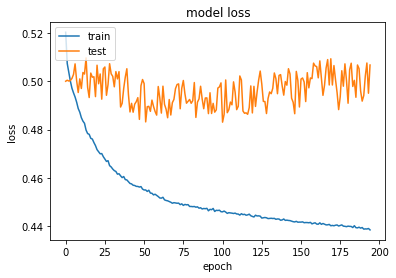

In [28]:
# plt.plot(history.history['f1_score'][:5])
# plt.plot(history.history['val_f1_score'][:5])
# plt.title('model f1_score')
# plt.ylabel('f1_score')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [215]:
y_pred = np.array(model.predict(dt_test))

In [217]:
y_pred

array([[-0.00281795,  0.0635457 ],
       [-0.01517533,  0.00731104],
       [ 0.00129437,  0.04663407],
       ...,
       [-0.00781078, -0.00079069],
       [-0.0427766 ,  0.04510085],
       [ 0.00332094,  0.04543925]], dtype=float32)

In [218]:
y_true

array([[ 0.16831734, -0.98573286],
       [ 0.97029573,  0.2419219 ],
       [ 0.14228343,  0.98982596],
       ...,
       [ 0.57785762,  0.81613759],
       [-0.56063899,  0.82806033],
       [ 0.89802758, -0.43993917]])

In [223]:
def decoder_atan2(data):
    sin_ = data[:, 0]
    cos_ = data[:, 1]
    radian_backazimuth = []
    for i in range(data.shape[0]):
        radian_backazimuth.append(math.atan2(sin_[i], cos_[i]))
    return np.array(radian_backazimuth)

X_true = np.array(np.concatenate([x for x, y in dt_test], axis=0))
y_true = np.array(np.concatenate([y for x, y in dt_test], axis=0))
y_pred = np.array(model.predict(dt_test))
y_pred_az = decoder_atan2(y_pred)
y_true_az = decoder_atan2(y_true)

# metric = tfa.metrics.RSquare(num_regressors=6000)
# metric.update_state(np.exp(y_true[:, 0])/100, np.exp(y_pred[:, 0])/100)
# result_s = round(metric.result().numpy()*100, 2)

# metric = tfa.metrics.RSquare(num_regressors=6000)
# metric.update_state(np.exp(y_true[:, 1])-1, np.exp(y_pred[:, 1])-1)
# result_mag = round(metric.result().numpy()*100, 2)

metric = tfa.metrics.RSquare(num_regressors=6000)
metric.update_state(y_true_az, y_pred_az)
result_az = round(metric.result().numpy()*100, 2)

# print(f'\nAdjusted-RSquared S-Wave : {result_s} %')
# print(f'Adjusted-RSquared Magnitude: {result_mag} %')
print(f'Adjusted-RSquared Azimuth  : {result_az} %\n')

# true_s = np.exp(y_true[:, 0])/100
# true_mag = np.exp(y_true[:, 1])-1
# pred_s = np.exp(y_pred[:, 0])/100
# pred_mag = np.exp(y_pred[:, 1])-1
# true_az = y_true[:, 2]
# pred_az = y_pred[:, 2]

# error_s = true_s-pred_s
# error_mag = true_mag-pred_mag
error_az = y_true_az-y_pred_az

# mean_error_s = np.mean(error_s)
# std_error_s = np.std(error_s)

# mean_error_mag = np.mean(error_mag)
# std_error_mag = np.std(error_mag)

mean_error_az = np.mean(error_az)
std_error_az = np.std(error_az)

# print(f'95.3% Confident Interval S-Wave: {round(mean_error_s-2*std_error_s, 2)} <> {round(mean_error_s+2*std_error_s, 2)} (Second)')
# print(f'95.3% Confident Interval Magnitude: {round(mean_error_mag-2*std_error_mag, 2)} <> {round(mean_error_mag+2*std_error_mag, 2)} (Schala Richter)')
print(f'95.3% Confident Interval Magnitude: {round(mean_error_az-2*std_error_az, 2)} <> {round(mean_error_az+2*std_error_az, 2)} (Degree)')

Adjusted-RSquared Azimuth  : -60.9 %

95.3% Confident Interval Magnitude: -3.88 <> 4.7 (Degree)


In [31]:
np.sum(y_true)

1442.3329280806315

In [29]:
np.sum(y_pred)

-248221.16

In [180]:
y_true[:5]

array([[ 0.5177284 , -0.85554503],
       [-0.7313537 ,  0.68199836],
       [-0.78574895,  0.61854554],
       [-0.45709793,  0.88941637],
       [ 0.99472074, -0.10261893]])

In [182]:
(math.atan2(0.5177284, -0.85554503))

2.597398990420469

In [185]:
y_test_backAzimuth

445420    2.597399
530363   -0.820305
916079   -0.903906
944529   -0.474730
875801    1.673596
            ...   
60096     2.926917
824728   -1.966812
229288   -2.806489
190924    2.600541
536022    1.937315
Name: back_azimuth_deg, Length: 257, dtype: float64

In [137]:
np.cos(5.771280)

0.8718127964790214

In [149]:
tf_atan2(-0.33380686, -0.94264149)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.9111356>

In [151]:
y.loc[311340]

s_arrival_sample    6.688355
source_magnitude    1.458615
back_azimuth_deg    4.372050
sin                -0.942641
cos                -0.333807
Name: 311340, dtype: float64

In [153]:
np.degrees(4.372050)

250.50001282017155

In [154]:
250.50-180

70.5

In [155]:
np.radians(70.5)

1.2304571226560024

In [156]:
np.sin(1.2304571226560024)

0.9426414910921784

In [157]:
np.cos(1.2304571226560024)

0.3338068592337709

In [158]:
tf_atan2(0.3338068592337709, 0.9426414910921784)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2304572>